<a href="https://colab.research.google.com/github/HurleyJames/GoogleColabExercise/blob/master/Image_Classification_with_Convolutional_Neural_Networks_ImageNet10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from  torch.utils.data import Dataset
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2

In [0]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

Cloning into 'imagenet10'...
remote: Enumerating objects: 10019, done.
remote: Total 10019 (delta 0), reused 0 (delta 0), pack-reused 10019
Receiving objects: 100% (10019/10019), 966.71 MiB | 41.16 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (10002/10002), done.


In [0]:
! ls

imagenet10  sample_data


In [0]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

In [0]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

In [0]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

In [0]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/orange/n07747607_11153.JPEG,9
1,imagenet10/train_set/football/n04254680_5865.JPEG,7
2,imagenet10/train_set/mug/n03797390_4910.JPEG,8
3,imagenet10/train_set/orange/n07747607_39514.JPEG,9
4,imagenet10/train_set/football/n04254680_4354.JPEG,7


In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

In [0]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs

In [0]:
norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [00:42<00:00, 211.88it/s]


(224, 224, 3, 9000)
normMean = [0.5228359, 0.4798834, 0.40605333]
normStd = [0.29770732, 0.28883994, 0.31178218]


In [0]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

In [0]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10
# test_split = 0.20

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)
# test_size = int(len(data_df)*test_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

create dataloader

In [0]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=24,
    # batch_size=10,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=24,
    # batch_size=15,
    shuffle=False,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=32,
    # batch_size=30,
    shuffle=False,
    num_workers=2
)

In [0]:
len(train_loader)

263

In [0]:
len(valid_loader)

38

In [0]:
len(test_loader)

57

# CNN

In [0]:
train = []
valid = []
train2 = []
train3 = []
train4 = []
train5 = []
valid2 = []
valid3 = []
valid4 = []
valid5 = []

testing support GPU or not

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### 2-conv-layer

In [0]:
# Convolutional neural network
class ConvNet2(nn.Module):

    def __init__(self, num_classes=10):
        super(ConvNet2, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 24, 4)
        
        self.fc1 = nn.Linear(24*62*62, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = x.view(-1, 24*62*62) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

model2 = ConvNet2()
print(model2)

ConvNet2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=92256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
)


### 3-conv-layer

In [0]:
# Convolutional neural network
class ConvNet3(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet3, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 24, 4)
        self.conv3 = nn.Conv2d(24, 32, 4)

        self.fc1 = nn.Linear(32*29*29, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.3)
        self.dropout3 = nn.Dropout2d(0.3)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        x = x.view(-1, 32*29*29) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

model3 = ConvNet3()
print(model3)

ConvNet3(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=26912, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=False)
)


### 4-conv-layer

In [0]:
# Convolutional neural network
class ConvNet4(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet4, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 24, 4)
        self.conv3 = nn.Conv2d(24, 32, 4)
        self.conv4 = nn.Conv2d(32, 40, 4)

        self.fc1 = nn.Linear(40*13*13, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.3)
        self.dropout3 = nn.Dropout2d(0.3)
        self.dropout4 = nn.Dropout2d(0.3)
        
    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        x = self.pool4(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(-1, 40*13*13) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

model4 = ConvNet4()
print(model4)

ConvNet4(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=False)
  (dropout4): Dropout2d(p=0.3, inplace=False)
)


### 5-conv-layer

In [0]:
# Convolutional neural network
class ConvNet5(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 24, 4)
        self.conv3 = nn.Conv2d(24, 32, 4)
        self.conv4 = nn.Conv2d(32, 40, 4)
        self.conv5 = nn.Conv2d(40, 48, 4)

        self.fc1 = nn.Linear(48*5*5, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
        self.pool4 = nn.MaxPool2d(2)
        self.pool5 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.3)
        self.dropout3 = nn.Dropout2d(0.3)
        self.dropout4 = nn.Dropout2d(0.3)
        self.dropout5 = nn.Dropout2d(0.3)

        
    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        x = self.pool4(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = self.pool5(F.relu(self.conv5(x)))
        x = self.dropout5(x)

        x = x.view(-1, 48*5*5) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

model5 = ConvNet5()
print(model5)

ConvNet5(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv5): Conv2d(40, 48, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=1200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=F

### define optimizer and loss function

In [0]:
from torch import optim

torch.manual_seed(0)

optimizer2 = optim.SGD(model2.parameters(), lr = 0.001, momentum = 0.9)
optimizer3 = optim.SGD(model3.parameters(), lr = 0.001, momentum = 0.9)
optimizer4 = optim.SGD(model4.parameters(), lr = 0.001, momentum = 0.9)
optimizer5 = optim.SGD(model5.parameters(), lr = 0.001, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()

put model on GPU

In [0]:
model2.to(device)

ConvNet2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=92256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
)

In [0]:
model3.to(device)

ConvNet3(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=26912, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=False)
)

In [0]:
model4.to(device)

ConvNet4(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=False)
  (dropout4): Dropout2d(p=0.3, inplace=False)
)

In [0]:
model5.to(device)

ConvNet5(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv5): Conv2d(40, 48, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=1200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=F

### 训练网络

the function of filter visualization

In [0]:
def filter_visual():
  figure = plt.figure(figsize = (15, 15))
  k = 0

  for i in range(16):
    
    filter_mix = np.zeros(shape = [3,3])
    for j in range(3):
      k = k + 1
      figure.add_subplot(8, 6, k)
      filter_mix += model.conv1.weight.data.cpu().numpy()[ i, j, :, :]
      plt.imshow(filter_mix, cmap = "gray")
  plt.show()

the list of loss and accuracy

In [0]:
loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

model2_train_loss = []
model2_valid_loss = []
model2_train_acc = []
model2_valid_acc = []

model3_train_loss = []
model3_valid_loss = []
model3_train_acc = []
model3_valid_acc = []

model4_train_loss = []
model4_valid_loss = []
model4_train_acc = []
model4_valid_acc = []

model5_train_loss = []
model5_valid_loss = []
model5_train_acc = []
model5_valid_acc = []

training epoch

In [0]:
EPOCH = 10

the function of training and validation

In [0]:
def train_and_valid(num_epochs, model, optimizer, flag):  
    for epoch in range(num_epochs): 
        correct = 0
        total = 0 # loop over the dataset multiple times

        running_loss = 0.0
        total_val_loss =0.0

        if (epoch ==5 and flag ==1):
            filter_visual()
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print our loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Epoch %d - Loss : %.3f' % (epoch+1,running_loss/len(train_loader)))
        print('The accuracy of training set is %.3f %%' % (correct/total*100))
        loss_lst.append(running_loss/len(train_loader))
        acc_lst.append(correct/total*100)

        with torch.no_grad():
            val_correct = 0 
            val_total = 0
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                    
                val_outputs = model(inputs)
                val_loss = loss_fn(val_outputs, labels)
                total_val_loss += val_loss.item()
                _,prediction = torch.max(val_outputs.data,1)
                val_total += labels.size(0)
                val_correct += (prediction == labels).sum().item()
        print("Validation loss = {:.2f}".format(total_val_loss / len(valid_loader)))
        print('The accuracy of Validation set is %.3f %%' %(val_correct/val_total*100))

        val_loss_lst.append(total_val_loss / len(valid_loader))
        val_acc_lst.append(val_correct/val_total*100)
        
    print('Finished')    

the function of draw confusion matrix

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    #fmt = '.2f' if normalize else 'd'
    fmt = '.0f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(100,100)) 

the function of draw loss or accuracy curve

In [0]:
def draw_plot(train, valid):
    x = np.arange(0, 10)

    plt.figure()
    plt.plot(x, train, "r", "-", linewidth=1)

    plt.plot(x, valid, "b", ":", linewidth=1)

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("finding converge by loss")

### training 2-layer model

In [0]:
model2.train()
train_and_valid(EPOCH, model2, optimizer2, 0)

model2_train_loss = loss_lst
model2_valid_loss = val_loss_lst
model2_train_acc = acc_lst
model2_valid_acc = val_acc_lst

loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

Epoch 1 - Loss : 2.169
The accuracy of training set is 20.540 %
Validation loss = 2.12
The accuracy of Validation set is 23.333 %
Epoch 2 - Loss : 2.035
The accuracy of training set is 27.937 %
Validation loss = 2.04
The accuracy of Validation set is 28.000 %
Epoch 3 - Loss : 1.938
The accuracy of training set is 32.683 %
Validation loss = 2.02
The accuracy of Validation set is 30.333 %
Epoch 4 - Loss : 1.882
The accuracy of training set is 36.429 %
Validation loss = 1.89
The accuracy of Validation set is 34.000 %
Epoch 5 - Loss : 1.753
The accuracy of training set is 40.270 %
Validation loss = 1.80
The accuracy of Validation set is 38.000 %
Epoch 6 - Loss : 1.621
The accuracy of training set is 45.556 %
Validation loss = 1.71
The accuracy of Validation set is 39.556 %
Epoch 7 - Loss : 1.511
The accuracy of training set is 49.413 %
Validation loss = 1.78
The accuracy of Validation set is 38.111 %
Epoch 8 - Loss : 1.411
The accuracy of training set is 52.397 %
Validation loss = 1.72
The

the loss image of training and validation dataset




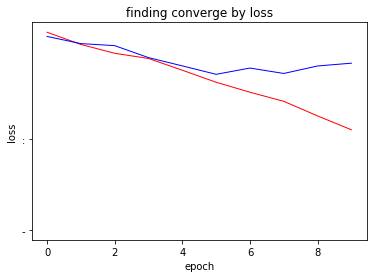

In [0]:
draw_plot(model2_train_loss, model2_valid_loss)

the accuracy of training and validation dataset

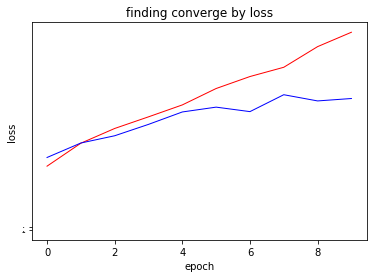

In [0]:
draw_plot(model2_train_acc, model2_valid_acc)

the accuracy of test dataset of 2-layer model

In [0]:
model2.eval()
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = torch.zeros(0, dtype=torch.long, device='cpu')
labels_pred = torch.zeros(0, dtype=torch.long, device='cpu')

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model2(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = torch.cat([labels_true, labels.view(-1).cpu()])
        labels_pred = torch.cat([labels_pred, predicted.view(-1).cpu()])

        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 810
total: 1800
Accuracy of the network on the images: 45 %
Accuracy of baboon: 55 %
Accuracy of banana: 31 %
Accuracy of canoe: 48 %
Accuracy of   cat: 41 %
Accuracy of  desk: 33 %
Accuracy of drill: 34 %
Accuracy of dumbbell: 31 %
Accuracy of football: 41 %
Accuracy of   mug: 43 %
Accuracy of orange: 80 %


confusion matrix

Normalized confusion matrix
[[ 92   1  13  21   6   3  18  17   3   2]
 [  4  78   8   3  11   2   0  16   3  61]
 [ 12   7  94   9  14   4  11  23   4   6]
 [ 27   7   5  63  13   3  19  28   7   3]
 [  9   3  19  11  65   8  37  12   5   5]
 [ 10   5   7  11  18  66  30  16  10   4]
 [ 15   6  12  13  28  15  77  10  12   7]
 [ 17  10  13  21  11   6   8  64  14   3]
 [ 13  13   5   5  22   3  24  17  81  14]
 [  2  21   1   1   4   0   1   3   6 130]]


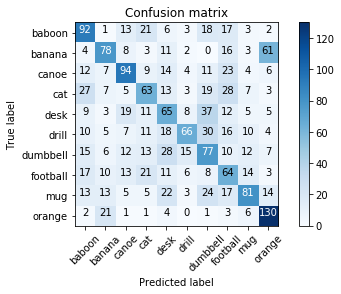

<Figure size 7200x7200 with 0 Axes>

In [0]:
cm = confusion_matrix(labels_true, labels_pred)
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

### training 3-layer model

In [0]:
model3.train()
train_and_valid(EPOCH, model3, optimizer3, 0)

model3_train_loss = loss_lst
model3_valid_loss = val_loss_lst
model3_train_acc = acc_lst
model3_valid_acc = val_acc_lst

loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

Epoch 1 - Loss : 2.260
The accuracy of training set is 14.111 %
Validation loss = 2.15
The accuracy of Validation set is 23.000 %
Epoch 2 - Loss : 2.077
The accuracy of training set is 25.413 %
Validation loss = 2.08
The accuracy of Validation set is 26.444 %
Epoch 3 - Loss : 1.990
The accuracy of training set is 29.460 %
Validation loss = 2.00
The accuracy of Validation set is 26.000 %
Epoch 4 - Loss : 1.918
The accuracy of training set is 31.778 %
Validation loss = 1.91
The accuracy of Validation set is 34.111 %
Epoch 5 - Loss : 1.858
The accuracy of training set is 34.603 %
Validation loss = 1.89
The accuracy of Validation set is 33.333 %
Epoch 6 - Loss : 1.785
The accuracy of training set is 36.603 %
Validation loss = 1.86
The accuracy of Validation set is 33.222 %
Epoch 7 - Loss : 1.748
The accuracy of training set is 39.333 %
Validation loss = 1.78
The accuracy of Validation set is 36.000 %
Epoch 8 - Loss : 1.680
The accuracy of training set is 41.333 %
Validation loss = 1.82
The

the loss images of training and validation dataset

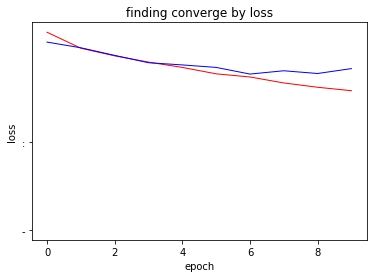

In [0]:
draw_plot(model3_train_loss, model3_valid_loss)

the accuracy images of training and validation dataset

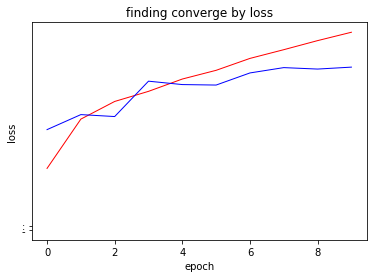

In [0]:
draw_plot(model3_train_acc, model3_valid_acc)

the accuracy of test dataset of 3-layer model

In [0]:
model3.eval()
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = torch.zeros(0, dtype=torch.long, device='cpu')
labels_pred = torch.zeros(0, dtype=torch.long, device='cpu')

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model3(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = torch.cat([labels_true, labels.view(-1).cpu()])
        labels_pred = torch.cat([labels_pred, predicted.view(-1).cpu()])

        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 691
total: 1800
Accuracy of the network on the images: 38 %
Accuracy of baboon: 66 %
Accuracy of banana: 13 %
Accuracy of canoe: 43 %
Accuracy of   cat: 63 %
Accuracy of  desk: 26 %
Accuracy of drill: 31 %
Accuracy of dumbbell: 12 %
Accuracy of football: 39 %
Accuracy of   mug: 27 %
Accuracy of orange: 87 %


confusion matrix

Normalized confusion matrix
[[108   1   7  45   4   0   2   5   1   3]
 [ 12  27   8  26   8   1   0  17   4  83]
 [ 30   1  61  44  29   0   1  16   1   1]
 [ 49   4   1  90  10   0   3  14   2   2]
 [ 22   3   9  24  68   2  15  18  10   3]
 [ 27   0   8  39   9  52  11   9  12  10]
 [ 52   6   2  31  31   6  38  11  12   6]
 [ 32   1   1  49   9   0   7  58   4   6]
 [ 43   7   2  33  19   0  11  15  50  17]
 [  2   6   5   6   2   0   0   2   7 139]]


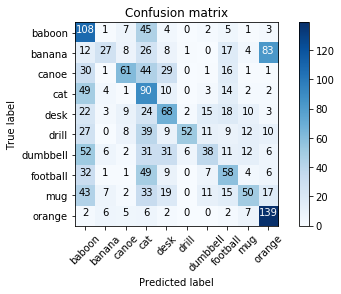

<Figure size 7200x7200 with 0 Axes>

In [0]:
cm = confusion_matrix(labels_true, labels_pred)
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

### training 4-layer model

In [0]:
model4.train()
train_and_valid(EPOCH, model4, optimizer4, 0)

model4_train_loss = loss_lst
model4_valid_loss = val_loss_lst
model4_train_acc = acc_lst
model4_valid_acc = val_acc_lst

loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

Epoch 1 - Loss : 2.300
The accuracy of training set is 10.190 %
Validation loss = 2.29
The accuracy of Validation set is 10.111 %
Epoch 2 - Loss : 2.231
The accuracy of training set is 14.000 %
Validation loss = 2.20
The accuracy of Validation set is 19.444 %
Epoch 3 - Loss : 2.138
The accuracy of training set is 20.333 %
Validation loss = 2.09
The accuracy of Validation set is 23.556 %
Epoch 4 - Loss : 2.068
The accuracy of training set is 24.238 %
Validation loss = 2.06
The accuracy of Validation set is 26.111 %
Epoch 5 - Loss : 2.024
The accuracy of training set is 28.302 %
Validation loss = 2.05
The accuracy of Validation set is 26.444 %
Epoch 6 - Loss : 1.997
The accuracy of training set is 28.698 %
Validation loss = 2.01
The accuracy of Validation set is 26.333 %
Epoch 7 - Loss : 1.971
The accuracy of training set is 30.857 %
Validation loss = 2.00
The accuracy of Validation set is 27.333 %
Epoch 8 - Loss : 1.926
The accuracy of training set is 32.429 %
Validation loss = 1.99
The

the loss images of training and validation dataset

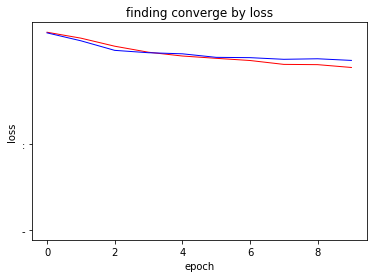

In [0]:
draw_plot(model4_train_loss, model4_valid_loss)

the accuracy of training and validation dateset

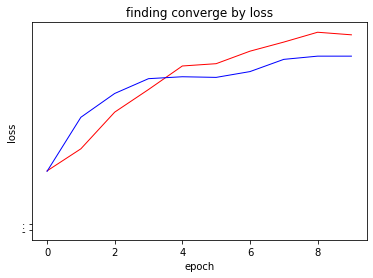

In [0]:
draw_plot(model4_train_acc, model4_valid_acc)

the accuracy of test dateset of 4-layer model

In [0]:
model4.eval()

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = torch.zeros(0, dtype=torch.long, device='cpu')
labels_pred = torch.zeros(0, dtype=torch.long, device='cpu')

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model4(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = torch.cat([labels_true, labels.view(-1).cpu()])
        labels_pred = torch.cat([labels_pred, predicted.view(-1).cpu()])

        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 598
total: 1800
Accuracy of the network on the images: 33 %
Accuracy of baboon: 60 %
Accuracy of banana: 59 %
Accuracy of canoe: 29 %
Accuracy of   cat:  0 %
Accuracy of  desk: 21 %
Accuracy of drill: 37 %
Accuracy of dumbbell: 34 %
Accuracy of football: 24 %
Accuracy of   mug: 14 %
Accuracy of orange: 43 %


confusion matrix

Normalized confusion matrix
[[104   6   7   0  18   2  17  12   9   1]
 [ 15 107  13   0   9   4   5   6   7  20]
 [ 37  11  72   0  29   2  13  17   2   1]
 [ 76  14  10   0  20   2  23  21   8   1]
 [ 28  15  21   0  46  11  26  16  10   1]
 [ 17  17  15   0  18  56  31   9  12   2]
 [ 32  13  10   0  33  12  73  13   9   0]
 [ 37  12  12   0  28   5  23  34  14   2]
 [ 29  34  12   0  27   4  41  14  33   3]
 [  3  82   5   0   5   0   0   0   1  73]]


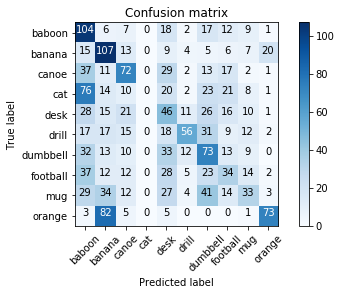

<Figure size 7200x7200 with 0 Axes>

In [0]:
cm = confusion_matrix(labels_true, labels_pred)
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

### training 5-layer model

In [0]:
model5.train()
train_and_valid(EPOCH, model5, optimizer5, 0)

model5_train_loss = loss_lst
model5_valid_loss = val_loss_lst
model5_train_acc = acc_lst
model5_valid_acc = val_acc_lst

loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

Epoch 1 - Loss : 2.302
The accuracy of training set is 9.968 %
Validation loss = 2.30
The accuracy of Validation set is 9.000 %
Epoch 2 - Loss : 2.302
The accuracy of training set is 11.000 %
Validation loss = 2.30
The accuracy of Validation set is 10.222 %
Epoch 3 - Loss : 2.301
The accuracy of training set is 12.032 %
Validation loss = 2.30
The accuracy of Validation set is 10.000 %
Epoch 4 - Loss : 2.299
The accuracy of training set is 14.063 %
Validation loss = 2.30
The accuracy of Validation set is 11.889 %
Epoch 5 - Loss : 2.265
The accuracy of training set is 15.651 %
Validation loss = 2.26
The accuracy of Validation set is 17.333 %
Epoch 6 - Loss : 2.237
The accuracy of training set is 20.333 %
Validation loss = 2.24
The accuracy of Validation set is 19.444 %
Epoch 7 - Loss : 2.188
The accuracy of training set is 21.873 %
Validation loss = 2.20
The accuracy of Validation set is 19.333 %
Epoch 8 - Loss : 2.142
The accuracy of training set is 21.571 %
Validation loss = 2.15
The a

the loss images of training and validation dataset

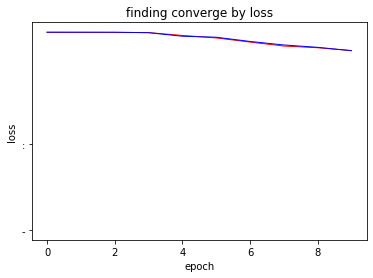

In [0]:
draw_plot(model5_train_loss, model5_valid_loss)

the accuracy of training and validation dataset

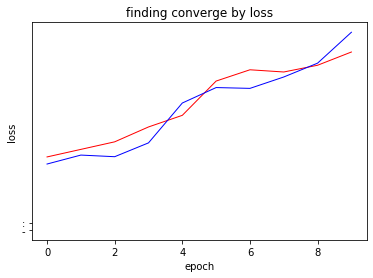

In [0]:
draw_plot(model5_train_acc, model5_valid_acc)

the accuracy of test dataset of 5-layer model

In [0]:
model5.eval()

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = torch.zeros(0, dtype=torch.long, device='cpu')
labels_pred = torch.zeros(0, dtype=torch.long, device='cpu')

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model5(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = torch.cat([labels_true, labels.view(-1).cpu()])
        labels_pred = torch.cat([labels_pred, predicted.view(-1).cpu()])

        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 495
total: 1800
Accuracy of the network on the images: 27 %
Accuracy of baboon: 62 %
Accuracy of banana:  2 %
Accuracy of canoe: 17 %
Accuracy of   cat:  0 %
Accuracy of  desk:  7 %
Accuracy of drill: 62 %
Accuracy of dumbbell:  8 %
Accuracy of football: 29 %
Accuracy of   mug:  0 %
Accuracy of orange: 92 %


confusion matrix

Normalized confusion matrix
[[121   2   1   0   2  11   4  31   0   4]
 [ 18   7  16   0   0  16   1  19   0 109]
 [ 30   3  30   0   4  40  29  44   0   4]
 [ 72   1   7   0   1  27  12  49   0   6]
 [ 33   2   8   0   8  43  15  57   0   8]
 [ 29   1   7   0   1  89   9  29   1  11]
 [ 57   3   7   0   5  47  29  42   0   5]
 [ 34   3   5   0   4  30  22  62   0   7]
 [ 44   3  14   0   4  41  20  49   0  22]
 [  2   3   5   0   0   6   1   3   0 149]]


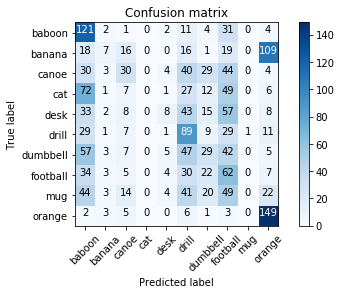

<Figure size 7200x7200 with 0 Axes>

In [0]:
cm = confusion_matrix(labels_true, labels_pred)
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

### use 4-layer model and change parameters

In [0]:
# Convolutional neural network
class ReConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ReConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 24, 4)
        self.conv3 = nn.Conv2d(24, 32, 4)
        self.conv4 = nn.Conv2d(32, 40, 4)

        self.fc1 = nn.Linear(40*13*13, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.1)
        self.dropout2 = nn.Dropout2d(0.1)
        self.dropout3 = nn.Dropout2d(0.1)
        self.dropout4 = nn.Dropout2d(0.1)
        
    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        x = self.pool4(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(-1, 40*13*13) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

    def retrieve_features(self, x):
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool1(feature_map1)
        x = F.dropout2d(x, 0.1)

        feature_map2 = F.relu(self.conv2(x))
        x = self.pool2(feature_map2)
        x = F.dropout2d(x, 0.1)

        feature_map3 = F.relu(self.conv3(x))
        x = self.pool3(feature_map3)
        x = F.dropout2d(x, 0.1)

        feature_map4 = F.relu(self.conv4(x))
        x = self.pool4(feature_map4)
        x = F.dropout2d(x, 0.1)

        # x = self.conv1(x)
        # feature_map1 = x
        # x = self.conv2[0](x)
        # feature_map2 = x
        # x = self.conv3[0](x)
        # feature_map3 = x
        # x = self.conv4[0](x)
        # feature_map4 = x

        return (feature_map1, feature_map2, feature_map3, feature_map4)

model = ReConvNet()
print(model)

ReConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (dropout4): Dropout2d(p=0.1, inplace=False)
)


define optimizer and loss function

In [0]:
from torch import optim

torch.manual_seed(0)

optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()

put model on GPU

In [0]:
model.to(device)

ReConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (dropout4): Dropout2d(p=0.1, inplace=False)
)

filter visualization before training

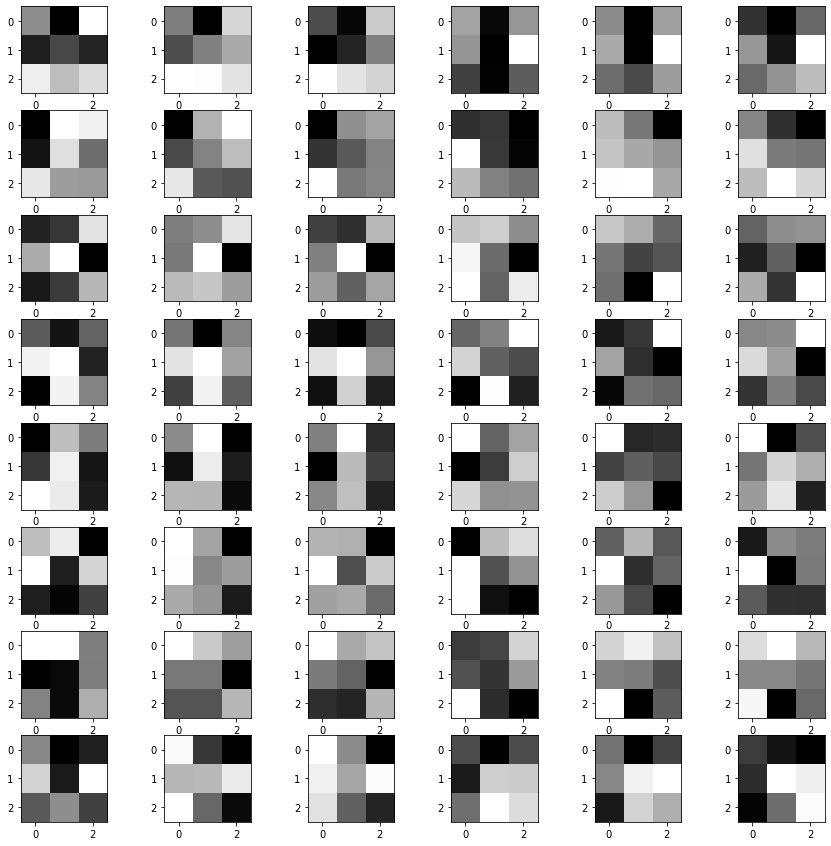

In [0]:
filter_visual()

In [0]:
retrain_loss = []
revalid_loss = []
retrain_acc = []
revalid_acc = []

training model and visualize filters during training

Epoch 1 - Loss : 2.299
The accuracy of training set is 10.714 %
Validation loss = 2.28
The accuracy of Validation set is 12.222 %
Epoch 2 - Loss : 2.238
The accuracy of training set is 15.127 %
Validation loss = 2.16
The accuracy of Validation set is 22.111 %
Epoch 3 - Loss : 2.158
The accuracy of training set is 22.333 %
Validation loss = 2.14
The accuracy of Validation set is 25.333 %
Epoch 4 - Loss : 2.050
The accuracy of training set is 26.873 %
Validation loss = 2.02
The accuracy of Validation set is 24.667 %
Epoch 5 - Loss : 1.923
The accuracy of training set is 32.016 %
Validation loss = 1.92
The accuracy of Validation set is 34.000 %


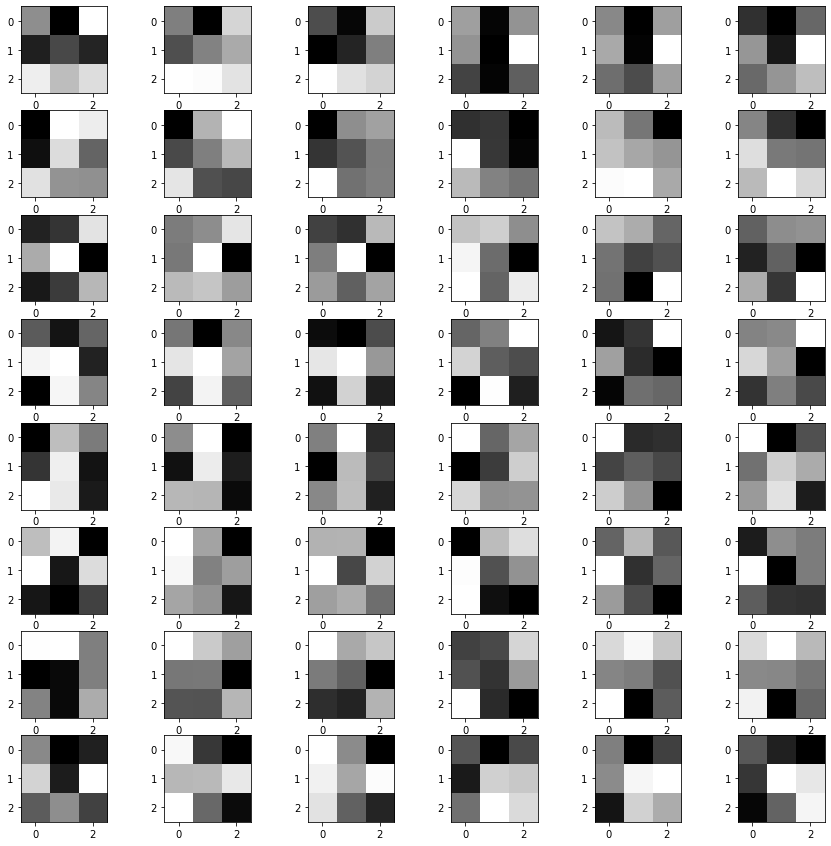

Epoch 6 - Loss : 1.848
The accuracy of training set is 35.556 %
Validation loss = 1.85
The accuracy of Validation set is 34.333 %
Epoch 7 - Loss : 1.776
The accuracy of training set is 37.508 %
Validation loss = 1.79
The accuracy of Validation set is 37.667 %
Epoch 8 - Loss : 1.718
The accuracy of training set is 40.952 %
Validation loss = 1.79
The accuracy of Validation set is 38.444 %
Epoch 9 - Loss : 1.658
The accuracy of training set is 42.730 %
Validation loss = 1.72
The accuracy of Validation set is 39.778 %
Epoch 10 - Loss : 1.615
The accuracy of training set is 43.746 %
Validation loss = 1.77
The accuracy of Validation set is 39.556 %
Finished


In [0]:
model.train()

train_and_valid(EPOCH, model, optimizer, 1)

retrain_loss = loss_lst
revalid_loss = val_loss_lst
retrain_acc = acc_lst
revalid_acc = val_acc_lst

loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

filter visualization after training

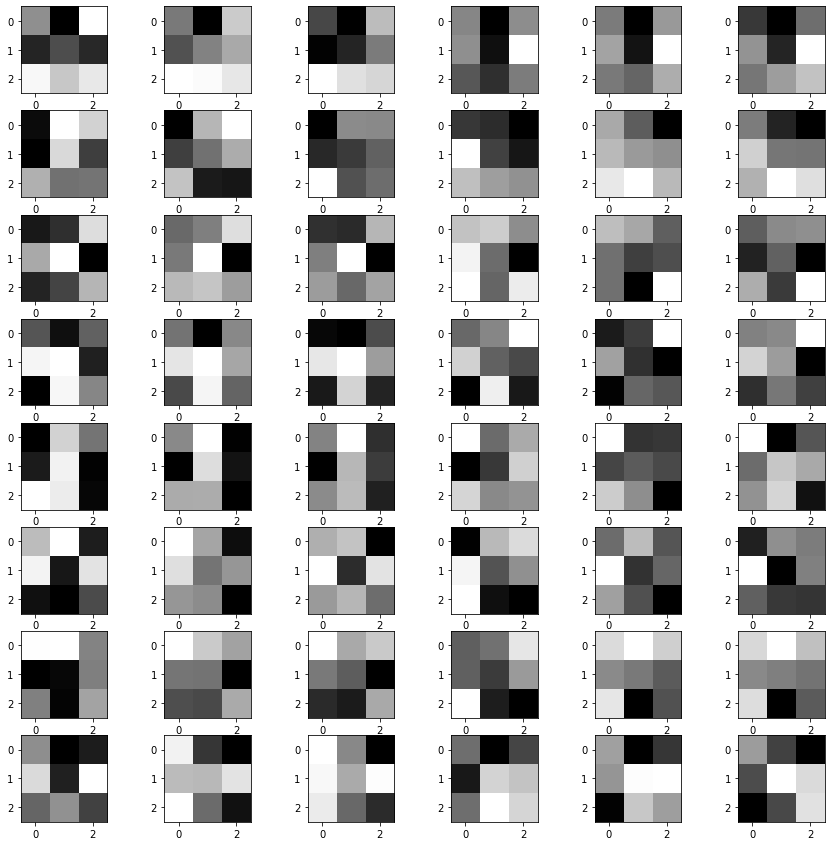

In [0]:
filter_visual()

the accuracy of test dataset

In [0]:
model.eval()

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = torch.zeros(0, dtype=torch.long, device='cpu')
labels_pred = torch.zeros(0, dtype=torch.long, device='cpu')

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = torch.cat([labels_true, labels.view(-1).cpu()])
        labels_pred = torch.cat([labels_pred, predicted.view(-1).cpu()])

        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 714
total: 1800
Accuracy of the network on the images: 39 %
Accuracy of baboon: 42 %
Accuracy of banana: 52 %
Accuracy of canoe: 41 %
Accuracy of   cat: 54 %
Accuracy of  desk: 14 %
Accuracy of drill: 44 %
Accuracy of dumbbell: 18 %
Accuracy of football: 34 %
Accuracy of   mug: 41 %
Accuracy of orange: 80 %


confusion matrix

Normalized confusion matrix
[[ 82   2  15  50   8   5   3   4   5   2]
 [  5  90   9  12   4   3   2   8  10  43]
 [ 16  11  86  26   8   6   5  11  12   3]
 [ 35  11   7  78   6   4   8  10  15   1]
 [ 20   8  21  17  38  12  21  13  18   6]
 [ 14  12  10  15  13  65  14   3  25   6]
 [ 31   7  12  21  14  25  45   8  23   9]
 [ 18  16  10  37   8   8  11  40  16   3]
 [ 25  21  11  14   9  11  16  10  61  19]
 [  1  25   1   4   2   0   1   1   5 129]]


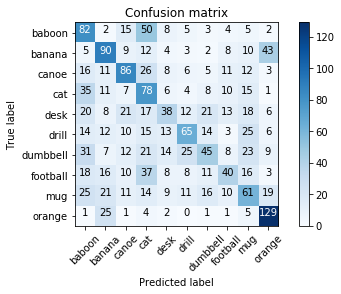

<Figure size 7200x7200 with 0 Axes>

In [0]:
cm = confusion_matrix(labels_true, labels_pred)
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

the loss image

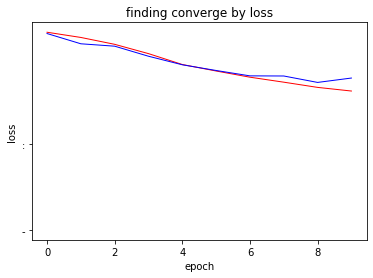

In [0]:
draw_plot(retrain_loss, revalid_loss)

the accuracy image

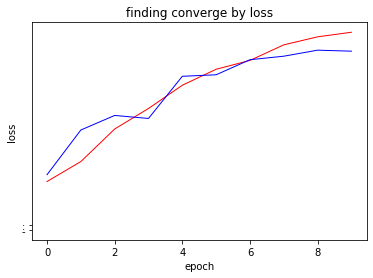

In [0]:
draw_plot(retrain_acc, revalid_acc)

# feature map visualization

draw feature map of first layer

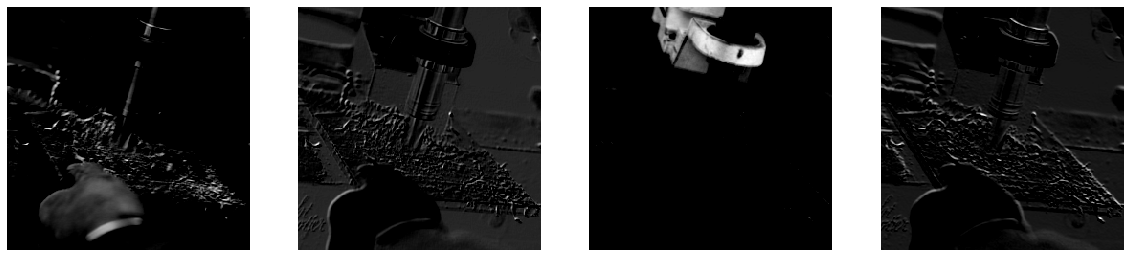

In [0]:
idx = 1000
idy = 500

input_x = ins_dataset_test[idx][0].unsqueeze(0)
input_y = ins_dataset_test[idy][0].unsqueeze(0)
feature_maps_x = model.retrieve_features(input_x.to(device))
feature_maps_y = model.retrieve_features(input_y.to(device))

plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_x[0][0, i, ...].data.cpu().numpy(), cmap='gray')

draw feature map of second layer

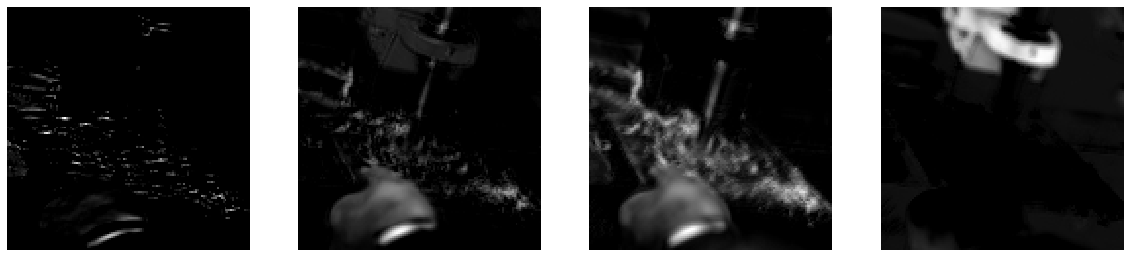

In [0]:
plt.figure(figsize = (20, 14))
for i in range(4):
    plt.subplot(2 ,4 ,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_x[1][0, i,...].data.cpu().numpy(), cmap='gray')

draw feature map of third layer

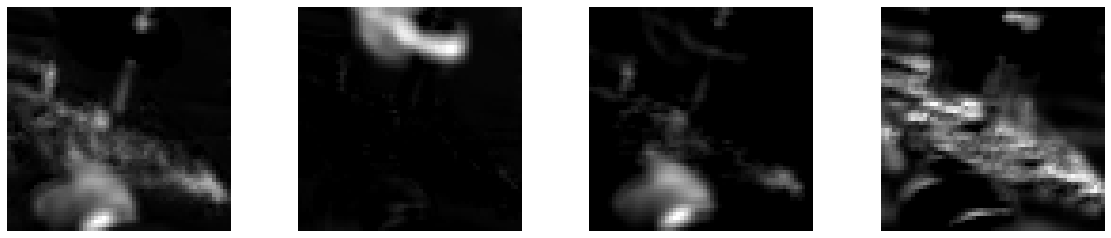

In [0]:
plt.figure(figsize = (20, 14))
for i in range(4):
    plt.subplot(3 ,4 ,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_x[2][0, i,...].data.cpu().numpy(), cmap='gray')

draw feature map of fourth layer

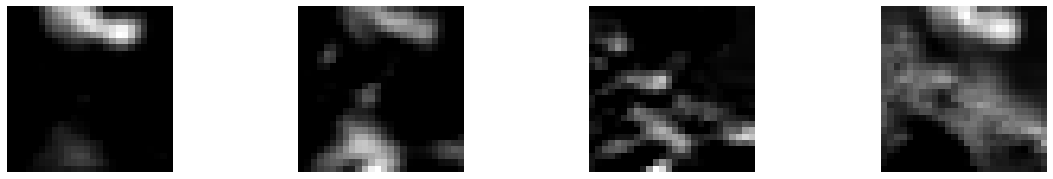

In [0]:
plt.figure(figsize = (20, 14))
for i in range(4):
    plt.subplot(4 ,4 ,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_x[3][0, i,...].data.cpu().numpy(), cmap='gray')

draw feature map of first layer

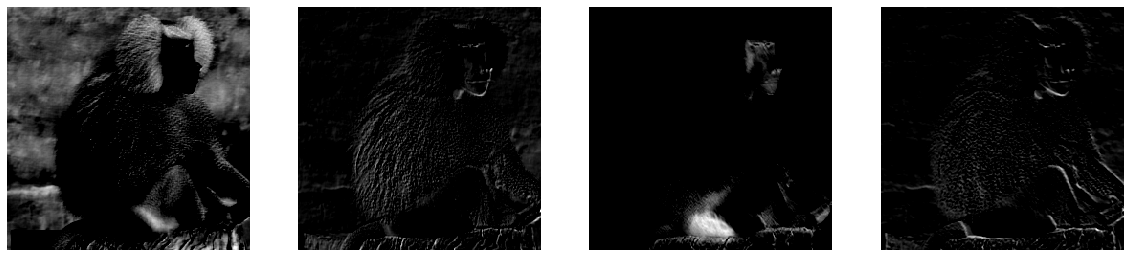

In [0]:
plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_y[0][0, i, ...].data.cpu().numpy(), cmap='gray')

draw feature map of second layer

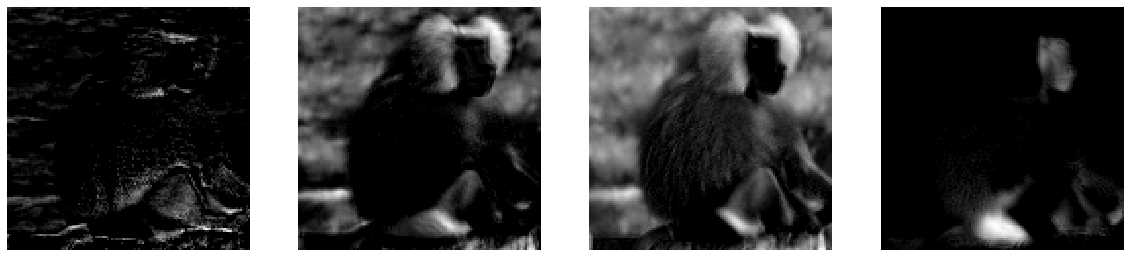

In [0]:
plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_y[1][0, i, ...].data.cpu().numpy(), cmap='gray')

draw feature map of third layer

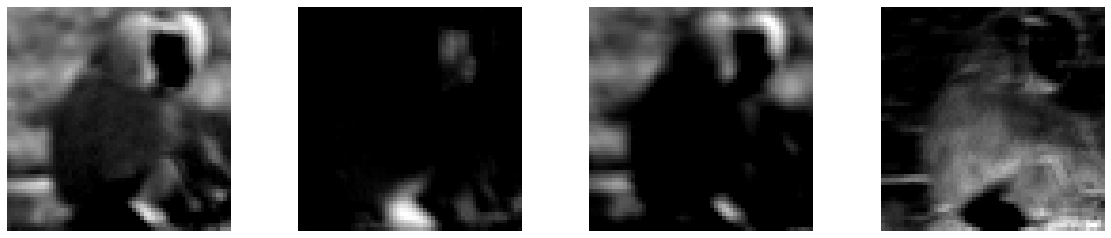

In [0]:
plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_y[2][0, i, ...].data.cpu().numpy(), cmap='gray')

draw feature map of fourth layer

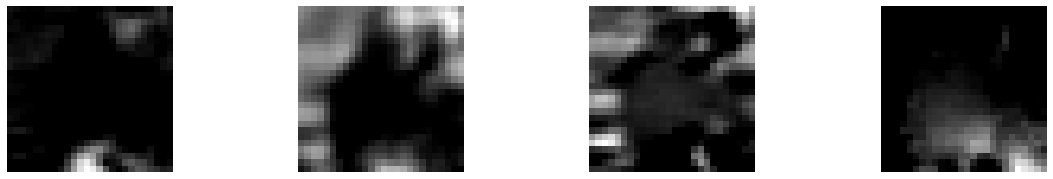

In [0]:
plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_y[3][0, i, ...].data.cpu().numpy(), cmap='gray')

# improving network performance

In [0]:
from torchvision import models

final_model = models.resnet18(pretrained = False)

for param in final_model.parameters():
    param.require_grad = False

final_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# from collections import OrderedDict

# classifier = nn.Sequential(OrderedDict([
#                             ('fc1', nn.Linear(25088, 4096)),
#                             ('relu1', nn.ReLU()),
#                             ('fc2', nn.Linear(4096, 1000)),
#                             ('relu2', nn.ReLU()),
#                             ('fc3', nn.Linear(1000, 10)),
#                             ('output', nn.LogSoftmax(dim=1))
# ]))

# final_model.classifier = classifier

define optimizer and loss function

In [0]:
loss_fn = nn.CrossEntropyLoss()
final_optimizer = optim.Adam(final_model.parameters(), lr = 0.001)

In [0]:
final_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
final_train_loss = []
final_valid_loss = []
final_train_acc = []
final_val_acc = []

In [0]:
train_and_valid(EPOCH, final_model, final_optimizer, 0)

Epoch 1 - Loss : 2.013
The accuracy of training set is 29.810 %
Validation loss = 1.82
The accuracy of Validation set is 36.000 %
Epoch 2 - Loss : 1.664
The accuracy of training set is 42.000 %
Validation loss = 1.55
The accuracy of Validation set is 43.667 %
Epoch 3 - Loss : 1.504
The accuracy of training set is 48.206 %
Validation loss = 1.48
The accuracy of Validation set is 50.111 %
Epoch 4 - Loss : 1.386
The accuracy of training set is 52.238 %
Validation loss = 1.37
The accuracy of Validation set is 52.111 %
Epoch 5 - Loss : 1.299
The accuracy of training set is 56.032 %
Validation loss = 1.33
The accuracy of Validation set is 54.444 %
Epoch 6 - Loss : 1.226
The accuracy of training set is 58.794 %
Validation loss = 1.34
The accuracy of Validation set is 54.111 %
Epoch 7 - Loss : 1.162
The accuracy of training set is 61.619 %
Validation loss = 1.22
The accuracy of Validation set is 58.000 %
Epoch 8 - Loss : 1.072
The accuracy of training set is 64.317 %
Validation loss = 1.16
The

In [0]:
final_train_loss = loss_lst
final_valid_loss = val_loss_lst
final_train_acc = acc_lst 
final_val_acc = val_acc_lst

loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

draw loss image

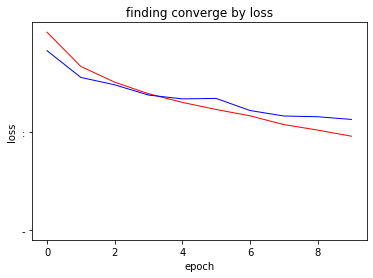

In [0]:
draw_plot(final_train_loss, final_valid_loss)

draw accuracy image

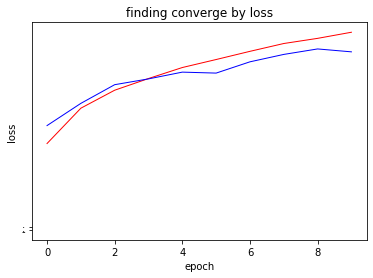

In [0]:
draw_plot(final_train_acc, final_val_acc)

the accuracy of test dataset

In [0]:
final_model.eval()

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = torch.zeros(0, dtype=torch.long, device='cpu')
labels_pred = torch.zeros(0, dtype=torch.long, device='cpu')

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = final_model(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = torch.cat([labels_true, labels.view(-1).cpu()])
        labels_pred = torch.cat([labels_pred, predicted.view(-1).cpu()])

        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 1162
total: 1800
Accuracy of the network on the images: 64 %
Accuracy of baboon: 91 %
Accuracy of banana: 43 %
Accuracy of canoe: 78 %
Accuracy of   cat: 58 %
Accuracy of  desk: 76 %
Accuracy of drill: 41 %
Accuracy of dumbbell: 65 %
Accuracy of football: 48 %
Accuracy of   mug: 49 %
Accuracy of orange: 85 %


confusion matrix

In [0]:
cm = confusion_matrix(labels_true, labels_pred)
print("Normalized confusion matrix:\n", cm)

Normalized confusion matrix:
 [[153   2   2  14   0   0   4   1   0   0]
 [  6  93   6   9   7   1   5   3   6  50]
 [ 22   2 128   2  11   4   5   8   2   0]
 [ 33   1   2 114   5   1  10   3   4   2]
 [  0   1   1   1 140   4  13   6   8   0]
 [  3   1   5   4  23  78  46  10   5   2]
 [ 11   5   1   4  13  13 127   7  11   3]
 [ 15  11   4   8   3   8  24  77  13   4]
 [  3   6   1   7  28   2  17  11 111  11]
 [  2   5   4   1   8   1   1   0   6 141]]


Normalized confusion matrix
[[153   2   2  14   0   0   4   1   0   0]
 [  6  93   6   9   7   1   5   3   6  50]
 [ 22   2 128   2  11   4   5   8   2   0]
 [ 33   1   2 114   5   1  10   3   4   2]
 [  0   1   1   1 140   4  13   6   8   0]
 [  3   1   5   4  23  78  46  10   5   2]
 [ 11   5   1   4  13  13 127   7  11   3]
 [ 15  11   4   8   3   8  24  77  13   4]
 [  3   6   1   7  28   2  17  11 111  11]
 [  2   5   4   1   8   1   1   0   6 141]]


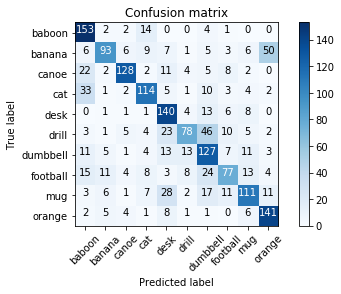

<Figure size 7200x7200 with 0 Axes>

In [0]:
plot_confusion_matrix(cm, class_names, 'Confusion matrix')